# A1: Data Curation
Xiaolu Qian

In this notebook, I combine data about Wikipedia page traffic from two different Wikimedia API endpoints into a single dataset, perform some simple data processing steps on the pageview traffic, and then analyze that data. I followed three major steps: <br>

- Step 1: Gathering the data
- Step 2: Processing the data
- Step 3: Analyzing the data

In [51]:
# import all useful libraries 
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Gathering the data

Mark ends points for both APIs, Lagacy API and pageview API.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Indicate parameters and header for both API calls

In [3]:
# parameters for getting aggregated legacy view data 
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }
# December 2007 through July 2016

# parameters for getting aggregated current standard pageview data
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020090100'
                        }
# July 2015 through last month

# Indicate the header for API calls
headers = {
    'User-Agent': 'https://github.com/XiaoluQianUW',
    'From': 'qianx6@uw.edu'
}

Function for the API calls

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Save the data from legacy API and write to seperate jsons for different types of traffic data

In [26]:
# access desktop and mobile traffic data for Legacy Pagecounts API
legacy_access = ['desktop-site', 'mobile-site']

legacy_output = './pagecounts_{}_200712-201607.json'

# get the data using API call function and write to json file 
for traffic_type in legacy_access:
    params = params_legacy
    params['access-site'] = traffic_type
    response = api_call(endpoint_legacy, params)
    
    with open(legacy_output.format(traffic_type), 'w') as outfile:
        json.dump(response, outfile)

Save the data from pageview API and write to seperate jsons for different types of traffic data 

In [27]:
# provides access to desktop, mobile web, and mobile app traffic data for Pageview API
pageviews_access = ['desktop', 'mobile-app', 'mobile-web']

pageviews_output = './pageviews_{}_201507-202008.json'

# get the data using API call function and write to json file
for traffic_type in pageviews_access:
    params = params_pageviews
    params['access'] = traffic_type
    response = api_call(endpoint_pageviews, params)
    
    with open(pageviews_output.format(traffic_type), 'w') as outfile:
        json.dump(response, outfile)

## Step 2: Processing the data

The goal is to create the final csv with the following columns:
- year
- month
- pagecount_all_views
- pagecount_desktop_views
- pagecount_mobile_views
- pageview_all_views
- pageview_desktop_views
- pageview_mobile_views

For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

In [87]:
def convert_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    return df

In this function, I read the json file, convert the timestamp to year, month, and rename the column for count/views to their specific API and traffic type. I keep only the necessary columns in each dataframe.

In [92]:
def read_json_def(json_file):
    file = pd.read_json(json_file)
    df = pd.DataFrame.from_dict(pd.json_normalize(file['items']), orient='columns')
    df = convert_time(df)
    if 'pagecounts_desktop' in json_file:
        data = df.rename(columns={'count':'pagecount_desktop_views'})
        data = data[['pagecount_desktop_views', 'year', 'month']].copy()
    if 'pagecounts_mobile' in json_file:
        data = df.rename(columns={'count':'pagecount_mobile_views'})
        data = data[['pagecount_mobile_views', 'year', 'month']].copy()
    if 'pageviews_desktop' in json_file:
        data = df.rename(columns={'views':'pageview_desktop_views'})
        data = data[['pageview_desktop_views', 'year', 'month']].copy()
    if 'pageviews_mobile-app' in json_file:
        data = df.rename(columns={'views':'pageview_mobile_app_views'})
        data = data[['pageview_mobile_app_views', 'year', 'month']].copy()
    if 'pageviews_mobile-web' in json_file:
        data = df.rename(columns={'views':'pageview_mobile_web_views'})
        data = data[['pageview_mobile_web_views', 'year', 'month']].copy()
        
    return data

convert all saved json files to dataframes

In [93]:
legacy_desktop = read_json_def('./json/pagecounts_desktop-site_200712-201607.json')
legacy_mobile = read_json_def('./json/pagecounts_mobile-site_200712-201607.json')
pageviews_desktop = read_json_def('./json/pageviews_desktop_201507-202008.json')
pageviews_mobile_app = read_json_def('./json/pageviews_mobile-app_201507-202008.json')
pageviews_mobile_web = read_json_def('./json/pageviews_mobile-web_201507-202008.json')

Merge all dataframs above together on year, month

In [101]:
processed_data = legacy_desktop[['year', 'month', 'pagecount_desktop_views']].merge(
        legacy_mobile[['year', 'month', 'pagecount_mobile_views']], how='outer', on= ['year', 'month']
    )\
    .merge(
        pageviews_desktop[['year', 'month', 'pageview_desktop_views']], how='outer', on= ['year', 'month']
    )\
    .merge(
        pageviews_mobile_app[['year', 'month', 'pageview_mobile_app_views']], how='outer', on= ['year', 'month']
    )\
    .merge(
        pageviews_mobile_web[['year', 'month', 'pageview_mobile_web_views']], how='outer', on= ['year', 'month']
    )

Fill in zeroes for nan values where the count/pageview for the particular year, month does not exist

In [108]:
processed_data = processed_data.fillna(0)

Combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month and combine the monthly values for destop and mobile traffic for each API to create a total traffic count. 

In [110]:
processed_data['pagecount_all_views'] = processed_data['pagecount_desktop_views'] +\
                                        processed_data['pagecount_mobile_views']

processed_data['pageview_mobile_views'] = processed_data['pageview_mobile_app_views'] +\
                                        processed_data['pageview_mobile_web_views']

processed_data['pageview_all_views'] = processed_data['pageview_mobile_views'] +\
                                        processed_data['pageview_desktop_views']

Reindex the dataframe and keep only columns that we needed

In [116]:
final_data = pd.DataFrame(processed_data).reindex(columns=['year', 'month', 'pagecount_all_views', 
                                                'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views'])

Save the dataframe to csv

In [119]:
final_data.to_csv('./en-wikipedia_traffic_200712-202008.csv', index=False)

## Step 3: Analyze the data

Reformat the date from year, month to datatime format for graphing the outputs

In [123]:
final_data['date'] = pd.to_datetime(final_data[['year', 'month']].assign(day = 1))

Rescale the data for better visualization by viewing all pageviews in millions

In [128]:
list_cols = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']

for col in list_cols:
    final_data[col] = (final_data[col]/1e6).astype(int)

Avoid unnecessary connection lines between 0 values

In [138]:
final_data = final_data.replace(to_replace = 0, value = np.nan)

visualize the traffic metrics from the two APIs as a time series graph

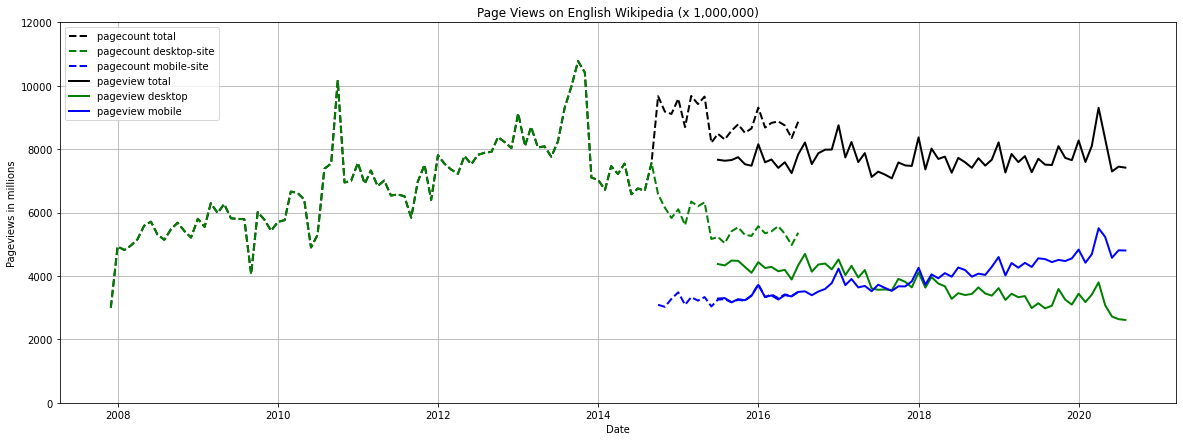

In [145]:
plt.figure(figsize = (20, 7))

# Plot for each API and its traffic types
plt.plot(final_data['date'], final_data['pagecount_all_views'], 
         color='black', linewidth=2, linestyle='dashed', label = "pagecount total")

plt.plot(final_data['date'], final_data['pagecount_desktop_views'], 
         color='green', linewidth=2, linestyle='dashed', label = "pagecount desktop-site")

plt.plot(final_data['date'], final_data['pagecount_mobile_views'], 
         color='blue', linewidth=2, linestyle='dashed', label = "pagecount mobile-site")

plt.plot(final_data['date'], final_data['pageview_all_views'], 
         color='black', linewidth=2, label = "pageview total")

plt.plot(final_data['date'], final_data['pageview_desktop_views'], 
         color='green', linewidth=2, label = "pageview desktop")

plt.plot(final_data['date'], final_data['pageview_mobile_views'], 
         color='blue', linewidth=2, label = "pageview mobile")


plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.xlabel('Date')
plt.ylabel('Pageviews in millions')
plt.legend()
plt.grid()
plt.ylim([0, 12000])


# save the png
plt.savefig('./en-wikipedia_traffic_200712-202008-fig.png')

Insight Analysis

From the graph, we see the difference between the two APIs in which data from the Pageview API (solid lines )excludes spiders/crawlers, while data from the Pagecounts API (dashed lines) does not. Because of the change of the metrics, we see a drop in total pageviews using the Pageview API. Since 2018, we also use the amount of pageviews assicoated with mobile users (blue solid line) exceeds the amount of pageviews with destop users (green solid line).